<a href="https://colab.research.google.com/github/cnsqhde/Test/blob/main/%EC%98%81%ED%99%94_%EC%B6%94%EC%B2%9C_%EC%8B%9C%EC%8A%A4%ED%85%9C_V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikit-surprise

In [ ]:
from surprise import Dataset
from surprise.model_selection import cross_validate

# ml-100k의 Data 분석 부분

In [ ]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import missingno as msno

from torch import nn
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [ ]:
# Google drive 마운트

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ml-100k 파일이 존재하는지 확인

os.listdir("../content")

['.config', 'drive', 'sample_data']

In [ ]:
# ml-100k의 데이터 정보 확인

information = pd.read_csv("/content/drive/MyDrive/ml-100k/u.info", sep=" ", header=None)
information.columns=['Counts', 'Type']
information

,Counts,Type
0,943,users
1,1682,items
2,100000,ratings


In [ ]:
# ml-100k의 사용자별 영화 평가 항목 확인

user_data = pd.read_csv('../content/drive/MyDrive/ml-100k/u.data', sep="\t", header=None)
user_data.columns = ['ser id', 'movie id', 'rating', 'timestamp']
user_data.head(10)

,ser id,movie id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
5,298,474,4,884182806
6,115,265,2,881171488
7,253,465,5,891628467
8,305,451,3,886324817
9,6,86,3,883603013


In [ ]:
# ml-100k의 평가를 진행한 사용자의 정보 확인 (사용자 ID, 나이, 성별, 직업군, 거주지)

users = pd.read_csv('../content/drive/MyDrive/ml-100k/u.user', sep="|", encoding='latin-1', header=None)
users.columns = ['user id', 'age', 'gender', 'occupation', 'zip code']
users.head(10)

,user id,age,gender,occupation,zip code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213
5,6,42,M,executive,98101
6,7,57,M,administrator,91344
7,8,36,M,administrator,05201
8,9,29,M,student,01002
9,10,53,M,lawyer,90703


In [ ]:
# ml-100k의 평가를 진행한 사용자 직업군 분류

jobs = pd.read_csv('../content/drive/MyDrive/ml-100k/u.occupation', sep="|", encoding='latin-1', header=None)
jobs.columns = ['Occupations']
jobs = list(jobs['Occupations'])
jobs

['administrator',
 'artist',
 'doctor',
 'educator',
 'engineer',
 'entertainment',
 'executive',
 'healthcare',
 'homemaker',
 'lawyer',
 'librarian',
 'marketing',
 'none',
 'other',
 'programmer',
 'retired',
 'salesman',
 'scientist',
 'student',
 'technician',
 'writer']

In [ ]:
# ml-100k의 영화 장르정보 확인

genre = pd.read_csv('../content/drive/MyDrive/ml-100k/u.genre', sep="|", encoding='latin-1', header=None)
genre.drop(genre.columns[1], axis=1, inplace=True)
genre.columns = ['Genres']
genre_list = list(genre['Genres'])
genre_list

['unknown',
 'Action',
 'Adventure',
 'Animation',
 "Children's",
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western']

In [ ]:
# ml-100k에서 제공하는 영화 정보 (영화 ID, 영화 제목, 개봉일, IMDB URL, 장르)

movies = pd.read_csv('../content/drive/MyDrive/ml-100k/u.item', sep="|", encoding='latin-1', header=None)
movies.columns = ['movie id', 'movie title' ,'release date','video release date', 'IMDb URL', 'unknown', 'Action', 
                  'Adventure', 'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 
                  'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
movies.head(10)

,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0
5,6,Shanghai Triad (Yao a yao yao dao waipo qiao) ...,01-Jan-1995,NaN,http://us.imdb.com/Title?Yao+a+yao+yao+dao+wai...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
6,7,Twelve Monkeys (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Twelve%20Monk...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
7,8,Babe (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Babe%20(1995),0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0
8,9,Dead Man Walking (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Dead%20Man%20...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
9,10,Richard III (1995),22-Jan-1996,NaN,http://us.imdb.com/M/title-exact?Richard%20III...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0


# 추천 시스템 (Collaborative Filtering)

1. Collaborative Filtering :  
  - 사용자가 평가한 항목간의 유사성을 고려하여 추천하는 방식  
  - 취향이 비슷한 집단에서 선호하는 아이템을 추천하는 방식으로 진행  
  - 직관적이기 때문에 분석할 필요가 없음  
  - Cold Start 문제 발생 (새로운 항목이 추가되는 경우 추천정보가 쌓이기 전까지 추천해주기 어려움)  
  - Long Tail 문제 발생 (선호도가 적은 항목에 대해 추천하기 어려움)  

- Collaborative Filtering에 사용하는 함수로는
  1. Dot Product
  2. Euclidean Distance  
  3. Cosine Similarity

In [ ]:
data = Dataset.load_builtin('ml-100k', prompt=False)  # 기본 제공 dataset load
# prompt = True인 경우 다운로드 할지 안할지 선택하는 창 보여줌
#          False인 경우 바로 다운로드
# Dataset module은 Dataset의 Class, subclass 정의함

data.raw_ratings[:10]
# 10개의 데이터 뽑아봄
# [사용자ID, 상품ID, 평점, 시간] 순으로 표시해줌

[('196', '242', 3.0, '881250949'),
 ('186', '302', 3.0, '891717742'),
 ('22', '377', 1.0, '878887116'),
 ('244', '51', 2.0, '880606923'),
 ('166', '346', 1.0, '886397596'),
 ('298', '474', 4.0, '884182806'),
 ('115', '265', 2.0, '881171488'),
 ('253', '465', 5.0, '891628467'),
 ('305', '451', 3.0, '886324817'),
 ('6', '86', 3.0, '883603013')]

In [ ]:
raw_data = np.array(data.raw_ratings, dtype=int)

raw_data[:10]
# raw_data 출력

array([[      196,       242,         3, 881250949],
       [      186,       302,         3, 891717742],
       [       22,       377,         1, 878887116],
       [      244,        51,         2, 880606923],
       [      166,       346,         1, 886397596],
       [      298,       474,         4, 884182806],
       [      115,       265,         2, 881171488],
       [      253,       465,         5, 891628467],
       [      305,       451,         3, 886324817],
       [        6,        86,         3, 883603013]])

In [ ]:
raw_data[:,0] -= 1
raw_data[:,1] -= 1

raw_data[:10]
# 사용자ID, 상품ID 시작 번호는 '1'에서 시작됨
# 사용자ID 갯수 : 943 / 상품ID 갯수 : 1682
# 1st, 2nd column의 값을 1씩 뺌 (0에서 시작되도록 만들기 위해)

array([[      194,       240,         3, 881250949],
       [      184,       300,         3, 891717742],
       [       20,       375,         1, 878887116],
       [      242,        49,         2, 880606923],
       [      164,       344,         1, 886397596],
       [      296,       472,         4, 884182806],
       [      113,       263,         2, 881171488],
       [      251,       463,         5, 891628467],
       [      303,       449,         3, 886324817],
       [        4,        84,         3, 883603013]])

In [ ]:
n_users = np.max(raw_data[:,0])
n_movies = np.max(raw_data[:,1])

print("number of users are",n_users," number of movies are", n_movies)
# raw_data의 사용자ID, 상품ID의 최대값을 찾음
# n_users = 942, n_movies = 1681

shape = (n_users + 1, n_movies + 1)
print("shape is", shape)
# 임의의 사용자(my_id)를 추가하기 위하여 shape + 1 추가

number of users are 941  number of movies are 1680
shape is (942, 1681)


In [ ]:
# 인접행렬 생성
# 제대로 동작하지 않는 경우, 한번 더 코드 시뮬레이션 진행해야함

adj_matrix = np.ndarray(shape, dtype=int)

# for [변수] in [문자열, 리스트, 튜플]
#     [수행부분]
# [문자열, 리스트, 튜플]을 순서대로 순회하면서 하나씩 [변수]에 넣어준다.
for user_id, movie_id, rating, time in raw_data:
    # adj_matrix[user_id][movie_id] = 1. # 모든 rating = 1로 설정하는 경우
    adj_matrix[user_id][movie_id] = rating  # rating을 파일값을 토대로 설정하는 경우
    
    # 해당 User_id에서 특정 Movie_id에 대한 rating, time이 있는경우 변환
    # 영화를 봤는지 안봤는지 표시해줌
    
adj_matrix
# np.ndarray 파일을 엑셀파일로 변환
#pd.DataFrame(adj_matrix).to_csv('adj_matrix.csv')

array([[0, 0, 0, ..., 0, 0, 4],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 5],
       [0, 0, 0, ..., 0, 0, 0],
       [5, 4, 3, ..., 0, 0, 5]])

#1. Dot Product

In [ ]:
# Dot Product

my_id, my_vector = 0, adj_matrix[0]               # 사실상 '사용자0' 을 나의 아이디로 만든 후 테스트 진행
print("my vector shape is", adj_matrix[0].shape)  # 0~1681개의 영화 모두를 의미 (총 1682개)
print("my vector is", adj_matrix[0])              # 0~1681개 영화 봤는지 여부 확인

best_match, best_match_id, best_match_vector = -1, -1, [] # default value 설정

for user_id, user_vector in enumerate(adj_matrix): # 인접행렬만큼 실행

  if my_id != user_id:
    similarity = np.dot(my_vector, user_vector)
    if similarity > best_match:
       best_match = similarity
       best_match_id = user_id
       best_match_vector = user_vector
       # 두 벡터를 내적한 값이 큰값을 Best match로 설정함
       # Simliarity가 best match보다 큰 경우, user_id, user_vector 대체함

print('Best Match: {}, Best Match ID: {}'.format(best_match, best_match_id))

my vector shape is (1681,)
my vector is [0 0 0 ... 0 0 4]
Best Match: 830, Best Match ID: 414


In [ ]:
# Recommend List 출력 (User_id가 안 본 영화 추천)

recommend_list = []
best_match_recommend_list = []

# https://jongminfire.dev/%ED%8C%8C%EC%9D%B4%EC%8D%AC-enumerate-zip
# enumerate : 인자의 값을 추출 할 때(?) 인덱스를 추출하는 기법
# zip : 인덱스와 함께 추출할 때 쓰는 기법

for i, log in enumerate(zip(my_vector, best_match_vector)):
  log1, log2 = log
  if log1 < 1. and log2 > 0.:    # my_vector = 0 / best_match_vector = 1 인경우
    recommend_list.append(i)     # my_id에게 추천하는 경우
#  elif log1 > 0. and log2 < 1.:         # my_vector = 1 / best_match_vector = 0 인경우
#    best_match_recommend_list.append(i) # best_match_id에게 추천하는 경우

print('Recommended movie list:',recommend_list)
# User_id가 본 movie중 my_id에서 보지않은 movie recommend list 출력
#print(best_match_recommend_list)
# User_id가 안본 movie중 my_id가 본 movie recommend list 출력

Recommended movie list: [0, 2, 5, 6, 7, 9, 10, 13, 15, 19, 20, 22, 25, 26, 27, 29, 30, 34, 36, 39, 40, 41, 42, 47, 49, 51, 52, 53, 54, 56, 62, 63, 64, 65, 67, 68, 69, 70, 71, 75, 76, 77, 78, 79, 80, 81, 83, 84, 85, 86, 88, 90, 91, 92, 93, 94, 95, 96, 97, 101, 103, 104, 105, 115, 116, 119, 120, 121, 122, 123, 124, 130, 131, 132, 134, 135, 138, 140, 141, 142, 145, 146, 148, 149, 151, 152, 153, 154, 155, 156, 157, 159, 162, 166, 170, 171, 172, 174, 176, 177, 179, 180, 181, 182, 183, 185, 189, 192, 193, 194, 195, 197, 198, 200, 201, 202, 207, 208, 209, 211, 213, 214, 215, 216, 217, 218, 221, 223, 224, 228, 229, 230, 232, 233, 236, 237, 238, 239, 243, 244, 246, 247, 248, 250, 251, 252, 257, 262, 263, 264, 266, 315, 316, 317, 320, 321, 324, 325, 326, 327, 328, 329, 330, 331, 336, 337, 343, 344, 345, 346, 351, 352, 354, 355, 362, 364, 365, 367, 373, 376, 383, 385, 386, 390, 391, 393, 394, 397, 399, 400, 401, 402, 403, 409, 410, 413, 414, 415, 416, 417, 418, 419, 421, 423, 425, 429, 430, 431, 

In [ ]:
movies.loc[recommend_list, ['movie id', 'movie title' ,'release date']]
# 보지 않은 영화목록 출력

,movie id,movie title,release date
0,1,Toy Story (1995),01-Jan-1995
2,3,Four Rooms (1995),01-Jan-1995
5,6,Shanghai Triad (Yao a yao yao dao waipo qiao) ...,01-Jan-1995
6,7,Twelve Monkeys (1995),01-Jan-1995
7,8,Babe (1995),01-Jan-1995
...,...,...,...
1514,1515,Wings of Courage (1995),01-Jan-1995
1515,1516,"Wedding Gift, The (1994)",01-Jan-1994
1519,1520,"Fear, The (1995)",01-Jan-1995
1538,1539,Being Human (1993),01-Jan-1993


#2. Euclidean Distance

  $$euclidean = \sqrt{\sum_{i=1}^{N} (A_i-B_i)^2}$$

In [ ]:
# Euclidean Distance = 두 점사이의 거리를 계산할 때 쓰는 방법
# 거리가 가까울수록(값이 작을수록) 사용자와 유사한 사용자를 추천함

my_id, my_vector = 0, adj_matrix[0]

best_match, best_match_id, best_match_vector = 9999, -1, [] # default value 설정

for user_id, user_vector in enumerate(adj_matrix):

  if my_id != user_id:
    euclidean_dist = np.sqrt(np.sum(np.square(my_vector - user_vector)))
    if euclidean_dist < best_match:
      best_match = euclidean_dist
      best_match_id = user_id
      best_match_vector = user_vector

print('Best Match: {}, Best Match ID: {}'.format(best_match, best_match_id))

Best Match: 25.632011235952593, Best Match ID: 699


In [ ]:
# Recommend List 출력 (User_id가 안 본 영화 추천)

recommend_list = []
best_match_recommend_list = []

for i, log in enumerate(zip(my_vector, best_match_vector)):
  log1, log2 = log
  if log1 < 1. and log2 > 0.:
    recommend_list.append(i)
#  elif log1 > 0. and log2 < 1.:         # my_vector = 1 / best_match_vector = 0 인경우
#    best_match_recommend_list.append(i) # best_match_id에게 추천하는 경우

print('Recommended movie list:',recommend_list)
# User_id가 본 movie중 my_id에서 보지않은 movie recommend list 출력
# print(best_match_recommend_list)
# User_id가 안본 movie중 my_id가 본 movie recommend list 출력

Recommended movie list: [122, 324, 326, 331, 342, 687, 688, 748, 749]


In [ ]:
movies.loc[recommend_list, ['movie id', 'movie title' ,'release date']]
# 보지 않은 영화목록 출력

,movie id,movie title,release date
122,123,"Frighteners, The (1996)",19-Jul-1996
324,325,Crash (1996),21-Mar-1997
326,327,Cop Land (1997),01-Jan-1997
331,332,Kiss the Girls (1997),01-Jan-1997
342,343,Alien: Resurrection (1997),01-Jan-1997
687,688,Leave It to Beaver (1997),22-Aug-1997
688,689,"Jackal, The (1997)",01-Jan-1997
748,749,"MatchMaker, The (1997)",01-Jan-1997
749,750,Amistad (1997),18-Dec-1997


#3. Cosine  Similarity
  $$cos(\theta)=\frac{A \cdot B}{\parallel A \parallel \times \parallel B \parallel} $$

In [ ]:
# Cosine SImilarity 함수
# 코사인 유사도 = 내적공간의 두 벡터간 각도의 코사인 값을 이용하여 측정한 벡터간 유사도
# 방향 같은경우 1, 수직인경우 0, 반대의경우 -1

def compute_cos_similarity(v1,v2):
  norm1 = np.sqrt(np.sum(np.square(v1)))
  norm2 = np.sqrt(np.sum(np.square(v2)))
  dot = np.dot(v1,v2)
  return dot / (norm1 * norm2)

In [ ]:
my_id, my_vector = 0, adj_matrix[0]

best_match, best_match_id, best_match_vector = -1, -1, []  # default value 설정

for user_id, user_vector in enumerate(adj_matrix):
  
  if my_id != user_id:
    cos_similarity = compute_cos_similarity(my_vector, user_vector)

    if cos_similarity > best_match:
      best_match = cos_similarity
      best_match_id = user_id
      best_match_vector = user_vector

print('Best Match: {}, Best Match ID: {}'.format(best_match, best_match_id))

Best Match: 0.5806357207498616, Best Match ID: 699


In [ ]:
# Recommend List 출력 (User_id가 안 본 영화 추천)

recommend_list = []
best_match_recommend_list = []

for i, log in enumerate(zip(my_vector, best_match_vector)):
  log1, log2 = log
  if log1 <1. and log2>0.:
    recommend_list.append(i)
#  elif log1 > 0. and log2 < 1.:         # my_vector = 1 / best_match_vector = 0 인경우
#    best_match_recommend_list.append(i) # best_match_id에게 추천하는 경우

print('Recommended movie list:',recommend_list)
# User_id가 본 movie중 my_id에서 보지않은 movie recommend list 출력
#print(best_match_recommend_list)
# User_id가 안본 movie중 my_id가 본 movie recommend list 출력

Recommended movie list: [122, 324, 326, 331, 342, 687, 688, 748, 749]


In [ ]:
movies.loc[recommend_list, ['movie id', 'movie title' ,'release date']]
# 보지 않은 영화목록 출력

,movie id,movie title,release date
122,123,"Frighteners, The (1996)",19-Jul-1996
324,325,Crash (1996),21-Mar-1997
326,327,Cop Land (1997),01-Jan-1997
331,332,Kiss the Girls (1997),01-Jan-1997
342,343,Alien: Resurrection (1997),01-Jan-1997
687,688,Leave It to Beaver (1997),22-Aug-1997
688,689,"Jackal, The (1997)",01-Jan-1997
748,749,"MatchMaker, The (1997)",01-Jan-1997
749,750,Amistad (1997),18-Dec-1997


# 추천 시스템 (Content Filtering)

2. Content Filtering :  
- 다른 사용자의 기록을 이용하지 않고, 사용자의 항목 자체를 분석하여 추천하는 방식을 의미  
- 컨텐츠 기반 필터링은 내용 자체를 분석하기 때문에 Collaborative Filtering에서 발생하는 Cold start 문제를 해결  
- 그러나, 비슷한 형식의 아이템만을 추천하기 때문에 다양한 항목을 추천하기 어려움  

- Content Filtering에 사용하는 함수로는  
  1. KNN (K-Nearest Neighbor)  
  2. SVD (Singular Value Decomposition)  
  3. SVD++ ('SVD' + 'implicit raings')  
  4. NMF (Non-negative Matrix Factorization)  

In [ ]:
from surprise import KNNBasic, SVD, SVDpp, NMF

In [ ]:
data = Dataset.load_builtin('ml-100k', prompt=False)

#1. KNN (K-Nearest Neighbor)
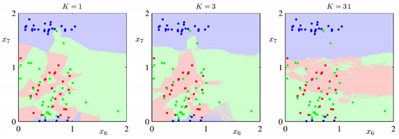

In [ ]:
# 기존의 데이터와 가장 가까운 K개의 데이터를 토대로 새로운 데이터를 예측하는 모델
# 따로 학습 절차가 없음
# 필요한 Hyper parameter로는 k(묶는 데이터 갯수), Distance가 있음
# k가 증가함에 따라서 분류 경계면이 단순해진다는것을 확인할 수 있음
# 가장 Fit time이 빠르다는 특징을 가짐

model = KNNBasic()
cross_validate(model, data, measures=['rmse', 'mae'], cv=5, n_jobs=4, verbose=True)

Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9735  0.9747  0.9852  0.9759  0.9797  0.9778  0.0042  
MAE (testset)     0.7708  0.7696  0.7783  0.7718  0.7732  0.7727  0.0030  
Fit time          0.46    0.58    0.73    0.73    0.54    0.61    0.11    
Test time         6.09    6.85    6.81    4.92    3.39    5.61    1.31    


{'fit_time': (0.45738816261291504,
  0.5847432613372803,
  0.7317445278167725,
  0.7301571369171143,
  0.535667896270752),
 'test_mae': array([0.77083175, 0.76957154, 0.77832279, 0.77179185, 0.77319366]),
 'test_rmse': array([0.97347476, 0.97474795, 0.9851883 , 0.97592246, 0.97974222]),
 'test_time': (6.09201455116272,
  6.848490953445435,
  6.8060009479522705,
  4.924126386642456,
  3.3864779472351074)}

#2. SVD (Singular Value Decomposition)
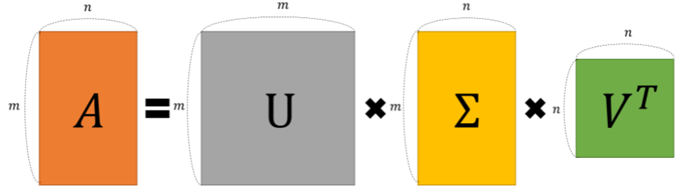

In [ ]:
# 행렬을 특정한 구조로 분해하는 방식
# A = M x N의 직사각 행렬
# U = M x M의 크기를 가지는 Unitary matrix
# ∑ = M x N의 크기의 대각선상 원소의 값은 음수가 아니며, 대각선 이외의 성분은 0인 대각 행렬
# V^T = N x N의 크기의 V matrix 의 conjugate transpose matrix로써, Unitary matrix의 형태를 가진다.

model = SVD()
cross_validate(model, data, measures=['rmse', 'mae'], cv=5, n_jobs=4, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9345  0.9277  0.9415  0.9380  0.9369  0.9357  0.0046  
MAE (testset)     0.7370  0.7331  0.7423  0.7388  0.7388  0.7380  0.0030  
Fit time          8.08    9.66    10.19   8.20    5.65    8.36    1.58    
Test time         0.47    0.50    0.30    0.22    0.15    0.33    0.14    


{'fit_time': (8.08268928527832,
  9.655492782592773,
  10.192808389663696,
  8.20238995552063,
  5.64909291267395),
 'test_mae': array([0.7369954 , 0.73306376, 0.74229569, 0.73882479, 0.73881638]),
 'test_rmse': array([0.93449007, 0.92774442, 0.94153722, 0.93804806, 0.93692718]),
 'test_time': (0.4679274559020996,
  0.49876904487609863,
  0.3017463684082031,
  0.21808624267578125,
  0.15376639366149902)}

#3. SVD++ ('SVD' + 'implicit raings')  

In [ ]:
# SVD 알고리즘에서 'Implicit Ratings'을 추가하여 예측의 정확도를 높이는 방식
# Fit time 오래걸리기 때문에 실제 활용하기 어렵다는 특징이 있음

#model = SVDpp()
#cross_validate(model, data, measures=['rmse', 'mae'], cv=5, n_jobs=4, verbose=True)

# 4. NMF (Non-negative Matrix Factorization)  

In [ ]:
# 음수를 포함하지 않은 행렬 V를 음수를 포함하지 않은 행렬 W와 H의 곱으로 분해하는 방식
# 행렬 분해는 정확한 해가 없기 때문에, 대략적인 해를 구하는데 사용
# V = W*H

model = NMF()
cross_validate(model, data, measures=['rmse', 'mae'], cv=5, n_jobs=4, verbose=True)

Evaluating RMSE, MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9667  0.9672  0.9675  0.9631  0.9573  0.9644  0.0039  
MAE (testset)     0.7579  0.7630  0.7592  0.7572  0.7523  0.7579  0.0034  
Fit time          8.98    10.90   10.80   9.13    6.16    9.19    1.72    
Test time         0.41    0.43    0.32    0.19    0.13    0.30    0.12    


{'fit_time': (8.977671384811401,
  10.90388798713684,
  10.79554271697998,
  9.132678747177124,
  6.159616470336914),
 'test_mae': array([0.7579022 , 0.7629646 , 0.75918316, 0.7572117 , 0.75230061]),
 'test_rmse': array([0.96669094, 0.96723273, 0.96750438, 0.96311444, 0.95733258]),
 'test_time': (0.40577030181884766,
  0.4290151596069336,
  0.3201570510864258,
  0.19266080856323242,
  0.13434314727783203)}

# 추천 시스템 (Hybrid Filtering)

3. Hybrid Filtering :  
- Content-based Filtering과 Collaborative Filtering을 조합하여 상호 보완적으로 개발한 알고리즘  
- 데이터가 없을때 발생하는 Cold Start 문제를 Content-based Filtering으로 해결  
- 충분한 데이터가 쌓인 후 Collaborative Filtering을 사용하여 정확성을 높이는 방식

#1. Content-based Filtering(행렬 분해)
 - Content-based Filtering에 사용할 함수는 Randomized SVD 사용
 - SVD는 standard gaussian vector를 사용하여 행렬 A의 near-best rank k 근사치를 계산
 - Randomized SVD는 multivariate Gaussian vectors를 사용하여 SVD보다 낮은 근사치 오류 달성 가능
 - Boullé, Nicolas, and Alex Townsend. "A generalization of the randomized singular value decomposition." arXiv preprint arXiv:2105.13052 (2021).

In [ ]:
from sklearn.decomposition import randomized_svd

In [ ]:
data = Dataset.load_builtin('ml-100k', prompt=False)

# 우선 Content-based Filtering 시작
raw_data = np.array(data.raw_ratings, dtype=int)
raw_data[:,0] -= 1
raw_data[:,1] -= 1

In [ ]:
n_users = np.max(raw_data[:,0])
n_movies = np.max(raw_data[:,1])
shape = (n_users +1, n_movies +1)
shape

(943, 1682)

In [ ]:
adj_matrix = np.ndarray(shape, dtype=int)
for user_id, movie_id, rating, time in raw_data:
  adj_matrix[user_id][movie_id] = rating

adj_matrix
# 인접행렬이 0~5가 아닌 다른 데이터가 안나오는 경우
# 위의 2개 코드를 다시한번 수행해줘야함

array([[5, 3, 4, ..., 0, 0, 0],
       [4, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [5, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 5, 0, ..., 0, 0, 0]])

In [ ]:
# randomized_svd(분해할 행렬, 추출할 특이값 및 벡터의 수)
U, S, V = randomized_svd(adj_matrix,n_components=2)  # U = 사용자, S = 특이값, V = 아이템 

# 특이값 행렬을 대각행렬로 변환시킴
S = np.diag(S)  # 대각행렬 생성

# 최종 vector = U * S * V.T

In [ ]:
print(U.shape)
print(S.shape)
print(V.shape)

(943, 2)
(2, 2)
(2, 1682)


#2-1. Collaborative Filtering (User based filtering)
- 나와 비슷한 취향을 가진 다른 사용자의 행동을 추천  
- 사용자 특징 벡터의 유사도 사용  
- Consine Similarity, Euclidean Distance 사용

In [ ]:
# Cosine SImilarity 함수 사용
# User based 이기때문에, 분해 행렬중 U matrix 사용

my_id, my_vector = 0, U[0]
best_match, best_match_id, best_match_vector = -1, -1, []

for user_id, user_vector in enumerate(U):
  if my_id != user_id:
    cos_similarity = compute_cos_similarity(my_vector, user_vector)
    if cos_similarity > best_match:
      best_match = cos_similarity
      best_match_id = user_id
      best_match_vector = user_vector

print('Best Match: {}, Best Match ID: {}'.format(best_match, best_match_id))

Best Match: 0.9999942295956324, Best Match ID: 235


In [ ]:
# Recommend List 출력 (User_id가 안 본 영화 추천)

recommend_list = []

for i, log in enumerate(zip(adj_matrix[my_id], adj_matrix[best_match_id])):
  log1, log2 = log
  if log1 <1. and log2>0.:
    recommend_list.append(i)

print('Recommended movie list:',recommend_list)

Recommended movie list: [272, 273, 274, 281, 285, 288, 293, 297, 303, 306, 312, 317, 327, 332, 369, 410, 418, 419, 422, 426, 428, 431, 434, 442, 461, 475, 477, 482, 495, 503, 504, 505, 506, 509, 519, 520, 522, 525, 531, 545, 548, 590, 594, 595, 613, 631, 654, 658, 660, 672, 684, 685, 691, 695, 698, 704, 716, 728, 734, 749, 755, 863, 865, 933, 1012, 1038, 1101, 1327, 1400]


In [ ]:
movies.loc[recommend_list, ['movie id', 'movie title' ,'release date']]
# 보지 않은 영화목록 출력

,movie id,movie title,release date
272,273,Heat (1995),01-Jan-1995
273,274,Sabrina (1995),01-Jan-1995
274,275,Sense and Sensibility (1995),01-Jan-1995
281,282,"Time to Kill, A (1996)",13-Jul-1996
285,286,"English Patient, The (1996)",15-Nov-1996
...,...,...,...
1012,1013,Anaconda (1997),11-Apr-1997
1038,1039,Hamlet (1996),24-Jan-1997
1101,1102,Two Much (1996),01-Jan-1996
1327,1328,Of Love and Shadows (1994),10-May-1996


In [ ]:
# Euclidean Distance 사용
# User based 이기때문에, 분해 행렬중 U matrix 사용

my_id, my_vector = 0, U[0]

best_match, best_match_id, best_match_vector = 9999, -1, [] # default value 설정

for user_id, user_vector in enumerate(U):
  if my_id != user_id:
    euclidean_dist = np.sqrt(np.sum(np.square(my_vector - user_vector)))
    if euclidean_dist < best_match:
      best_match = euclidean_dist
      best_match_id = user_id
      best_match_vector = user_vector

print('Best Match: {}, Best Match ID: {}'.format(best_match, best_match_id))

Best Match: 0.002592348683135199, Best Match ID: 200


In [ ]:
# Recommend List 출력 (User_id가 안 본 영화 추천)

recommend_list = []

for i, log in enumerate(zip(adj_matrix[my_id], adj_matrix[best_match_id])):
  log1, log2 = log
  if log1 <1. and log2>0.:
    recommend_list.append(i)

print('Recommended movie list:',recommend_list)

Recommended movie list: [94, 170, 171, 177, 189, 193, 202, 316, 421, 479, 482, 513, 514, 602]


In [ ]:
movies.loc[recommend_list, ['movie id', 'movie title' ,'release date']]
# 보지 않은 영화목록 출력

,movie id,movie title,release date
94,95,Aladdin (1992),01-Jan-1992
170,171,Delicatessen (1991),01-Jan-1991
171,172,"Empire Strikes Back, The (1980)",01-Jan-1980
177,178,12 Angry Men (1957),01-Jan-1957
189,190,Henry V (1989),01-Jan-1989
193,194,"Sting, The (1973)",01-Jan-1973
202,203,Unforgiven (1992),01-Jan-1992
316,317,In the Name of the Father (1993),01-Jan-1993
421,422,Aladdin and the King of Thieves (1996),01-Jan-1996
479,480,North by Northwest (1959),01-Jan-1959


#2-2. Collaborative Filtering (Content based filtering)
- 내가 본 항목과 비슷한 항목을 추천  
- 항목 특징 벡터의 유사도 사용  
- Consine Similarity, Euclidean Distance 사용

In [ ]:
# Cosine SImilarity 함수 사용
# Content based 이기때문에, 분해 행렬중 V.T matrix 사용

my_id, my_vector = 0, V.T[0]
best_match, best_match_id, best_match_vector = -1, -1, []

for user_id, user_vector in enumerate(V.T):
  if my_id != user_id:
    cos_similarity = compute_cos_similarity(my_vector, user_vector)
    if cos_similarity > best_match:
      best_match = cos_similarity
      best_match_id = user_id
      best_match_vector = user_vector

print('Best Match: {}, Best Match ID: {}'.format(best_match, best_match_id))

Best Match: 0.9999999951364145, Best Match ID: 1287


In [ ]:
# Recommend List 출력 (User_id가 안 본 영화 추천)

recommend_list = []

for i, user_vector in enumerate(adj_matrix):
  if adj_matrix[i][my_id] > 0.9:
    recommend_list.append(i)

print('Recommended movie list:',recommend_list)
# User_id가 본 movie중 my_id에서 보지않은 movie recommend list 출력

Recommended movie list: [3, 11, 20, 28, 40, 47, 62, 70, 81, 85, 90, 93, 100, 108, 128, 176, 191, 195, 198, 199, 205, 211, 215, 220, 232, 247, 248, 254, 265, 266, 269, 274, 277, 278, 290, 291, 299, 301, 303, 318, 323, 325, 344, 361, 371, 372, 376, 377, 383, 385, 391, 396, 397, 403, 405, 414, 423, 427, 433, 440, 448, 453, 464, 470, 482, 485, 493, 495, 504, 519, 530, 534, 541, 549, 559, 564, 598, 616, 619, 620, 625, 630, 638, 640, 641, 646, 648, 651, 653, 658, 669, 680, 684, 703, 707, 713, 725, 736, 744, 747, 749, 755, 762, 771, 772, 788, 793, 794, 796, 802, 804, 805, 813, 824, 828, 842, 844, 862, 866, 868, 878, 884, 887, 890, 894, 897, 914, 922, 932, 941]


In [ ]:
movies.loc[recommend_list, ['movie id', 'movie title' ,'release date']]
# 보지 않은 영화목록 출력

,movie id,movie title,release date
3,4,Get Shorty (1995),01-Jan-1995
11,12,"Usual Suspects, The (1995)",14-Aug-1995
20,21,Muppet Treasure Island (1996),16-Feb-1996
28,29,Batman Forever (1995),01-Jan-1995
40,41,Billy Madison (1995),01-Jan-1995
...,...,...,...
897,898,"Postman, The (1997)",01-Jan-1997
914,915,Primary Colors (1998),20-Mar-1998
922,923,Raise the Red Lantern (1991),01-Jan-1991
932,933,"Funeral, The (1996)",25-Oct-1996


In [ ]:
# Euclidean Distance 사용
# Content based 이기때문에, 분해 행렬중 V.T matrix 사용

my_id, my_vector = 0, V.T[0]

best_match, best_match_id, best_match_vector = 9999, -1, [] # default value 설정

for user_id, user_vector in enumerate(V.T):
  if my_id != user_id:
    euclidean_dist = np.sqrt(np.sum(np.square(my_vector - user_vector)))
    if euclidean_dist < best_match:
      best_match = euclidean_dist
      best_match_id = user_id
      best_match_vector = user_vector

print('Best Match: {}, Best Match ID: {}'.format(best_match, best_match_id))

Best Match: 0.013006545668797826, Best Match ID: 6


In [ ]:
# Recommend List 출력 (User_id가 안 본 영화 추천)

recommend_list = []

for i, user_vector in enumerate(adj_matrix):
  if adj_matrix[i][my_id] > 0.9:
    recommend_list.append(i)

print('Recommended movie list:',recommend_list)
# User_id가 본 movie중 my_id에서 보지않은 movie recommend list 출력

Recommended movie list: [3, 11, 20, 28, 40, 47, 62, 70, 81, 85, 90, 93, 100, 108, 128, 176, 191, 195, 198, 199, 205, 211, 215, 220, 232, 247, 248, 254, 265, 266, 269, 274, 277, 278, 290, 291, 299, 301, 303, 318, 323, 325, 344, 361, 371, 372, 376, 377, 383, 385, 391, 396, 397, 403, 405, 414, 423, 427, 433, 440, 448, 453, 464, 470, 482, 485, 493, 495, 504, 519, 530, 534, 541, 549, 559, 564, 598, 616, 619, 620, 625, 630, 638, 640, 641, 646, 648, 651, 653, 658, 669, 680, 684, 703, 707, 713, 725, 736, 744, 747, 749, 755, 762, 771, 772, 788, 793, 794, 796, 802, 804, 805, 813, 824, 828, 842, 844, 862, 866, 868, 878, 884, 887, 890, 894, 897, 914, 922, 932, 941]


In [ ]:
movies.loc[recommend_list, ['movie id', 'movie title' ,'release date']]
# 보지 않은 영화목록 출력

,movie id,movie title,release date
3,4,Get Shorty (1995),01-Jan-1995
11,12,"Usual Suspects, The (1995)",14-Aug-1995
20,21,Muppet Treasure Island (1996),16-Feb-1996
28,29,Batman Forever (1995),01-Jan-1995
40,41,Billy Madison (1995),01-Jan-1995
...,...,...,...
897,898,"Postman, The (1997)",01-Jan-1997
914,915,Primary Colors (1998),20-Mar-1998
922,923,Raise the Red Lantern (1991),01-Jan-1991
932,933,"Funeral, The (1996)",25-Oct-1996
